In [12]:
# ==========================================================
# FILE: deepmd_training_nmc.ipynb
# PURPOSE: Train and validate a Deep Potential model from VASP (OUTCAR) data of NMC
# ==========================================================

# ===========================================
# REQUIREMENTS (Environment Setup)
# ===========================================
# This script is designed to be executed in a Jupyter Notebook or Google Colab environment.
# Make sure you have Jupyter or JupyterLab installed and run this file inside it
# to visualize plots and outputs directly within the notebook.
#
# To run this notebook successfully, ensure the following environment
# is properly installed and configured:
#
# 1. Python 3.8+  (recommended: Python 3.10)
# 2. CUDA Toolkit 11.x or 12.x  (for GPU acceleration)
# 3. cuDNN 8.x  (compatible with your CUDA version)
# 4. TensorFlow >= 2.10  (GPU-enabled build)
# 5. DeePMD-kit  (dp, dpdata, deepmd) compatible with your TensorFlow version
# 6. dpdata >= 0.2.20
# 7. NumPy, Matplotlib, scikit-learn
#
# Test GPU availability:
#   python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"
# ===========================================

# ===========================================
# *** Input Data: OUTCAR file (exported from VASP) containing structural and atomic energy information of the material (e.g., NMC622 sample)
#
# *** Data Preparation and Model Training (script in cell 1 of the notebook)
#  - Read the OUTCAR data and split it into training and validation sets.
#  - Create the folders training_data and validation_data.
#  - Edit the configuration file input.json (number of training steps, neural network layers, sel parameters, etc.).
#  - Run Deep Potential (DP) model training to generate the files graph.pb and graph-compress.pb – the trained deep potential model.
#
# *** Model Evaluation and Plotting (script in cell 2 of the notebook)
#  - Use the trained model to test on the validation dataset.
#  - Generate result files:
#    + lcurve.out → training loss and error over steps
#    + tests.e.out → comparison between predicted and DFT reference energies
#  - Display plots directly in the notebook:
#    + Learning curve: shows loss/error vs. training steps
#    + Prediction vs Data: compares model-predicted energies with DFT reference data
#
# *** Final Outputs:
#  - DP model: graph-compress.pb – used for LAMMPS simulation (pair_style deepmd)
#  - Result plots: lcurve.png, tests.e.png – used to evaluate model accuracy
# ===========================================


import os
import dpdata
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ===========================================
# DEFINE ROOT DIRECTORY
# ===========================================
# Define the absolute path to the main working directory.
# This directory must contain both "00_data" and "01_train" subfolders.
root_dir = os.path.abspath("/home/tvt/Python/DeePMD/12-10-2025-respone-RSC/NMC622/0.75/300K")
print("Root directory:", root_dir)

# ===========================================
# STEP 1: DATA PREPARATION
# ===========================================
# Navigate to the data directory and load the OUTCAR file.
# dpdata will read atomic structures, energies, and forces for DeepMD training.
os.chdir(os.path.join(root_dir, "00_data"))
data = dpdata.LabeledSystem(
    os.path.join(root_dir, "MD_075NMC622_500step-300K"), fmt="vasp/outcar"
)
print(f"# The dataset contains {len(data)} frames")
NFrames = len(data)

# Split data into training (80%) and validation (20%) sets
index_validation = np.random.choice(NFrames, size=int(0.2 * NFrames), replace=False)
index_training = list(set(range(NFrames)) - set(index_validation))

# Create DeepMD-compatible subsystems
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)

# Export data to DeepMD numpy format
data_training.to_deepmd_npy("training_data")
data_validation.to_deepmd_npy("validation_data")
print(f"# Training data: {len(data_training)} frames")
print(f"# Validation data: {len(data_validation)} frames")


# ===========================================
# STEP 2: MODIFY input.json CONFIGURATION
# ===========================================
# Load the training configuration file
input_json = os.path.join(root_dir, "01_train", "input.json")
with open(input_json) as f:
    fp = json.load(f)

# Modify training parameters
fp["training"]["numb_steps"] = 10000  # Total training steps. Increasing this value to improve model accuracy.

# Define element types and descriptor settings
fp["model"]["type_map"] = ["Li", "Ni", "O", "Mn", "Co"]
fp["model"]["descriptor"]["sel"] = [26, 22, 60, 10, 10]  # neighbor selection numbers per element
fp["model"]["descriptor"]["neuron"] = [20, 40, 60]       # neural network layer configuration

# Save updated configuration
with open(input_json, "w") as f:
    json.dump(fp, f, indent=2)

print("\nUpdated input.json configuration:")
print(json.dumps(fp, indent=2))


# ===========================================
# STEP 3: TRAINING, FREEZING, AND TESTING
# ===========================================
train_dir = os.path.join(root_dir, "01_train")
os.chdir(train_dir)

# Train the Deep Potential model
!dp train input.json

# Freeze the trained model into graph.pb
!dp freeze -o graph.pb

# Compress the model graph for deployment
!dp compress -i graph.pb -o graph-compress.pb

# Run validation tests
!dp test -m graph-compress.pb -s ../00_data/validation_data -n 100 -d tests


# ===========================================
# END OF SCRIPT
# ===========================================
# Notes:
# - You can re-run this cell multiple times safely because root_dir is fixed.
# - If you move the working directory, update `root_dir` at the top.
# - For automation: consider wrapping training and testing in a try/except block for robustness.
# ▶ Run the next cell to plot the learning curve and prediction results.

Root directory: /home/tvt/Python/DeePMD/12-10-2025-respone-RSC/NMC622/0.75/300K
# The dataset contains 500 frames
# Training data: 400 frames
# Validation data: 100 frames

Updated input.json configuration:
{
  "_comment": "that's all",
  "model": {
    "type_map": [
      "Li",
      "Ni",
      "O",
      "Mn",
      "Co"
    ],
    "descriptor": {
      "type": "se_e2_a",
      "sel": [
        26,
        22,
        60,
        10,
        10
      ],
      "rcut_smth": 0.5,
      "rcut": 6.0,
      "neuron": [
        20,
        40,
        60
      ],
      "resnet_dt": false,
      "axis_neuron": 4,
      "seed": 1,
      "_comment": "that's all"
    },
    "fitting_net": {
      "neuron": [
        100,
        100,
        100
      ],
      "resnet_dt": true,
      "seed": 1,
      "_comment": "that's all"
    },
    "_comment": "that's all"
  },
  "learning_rate": {
    "type": "exp",
    "decay_steps": 5000,
    "start_lr": 0.001,
    "stop_lr": 3.51e-08,
    "_comment": 

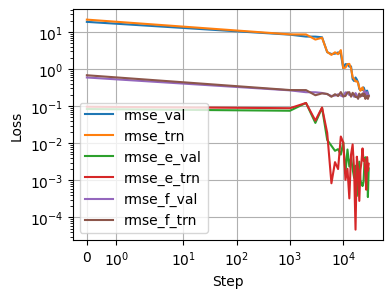

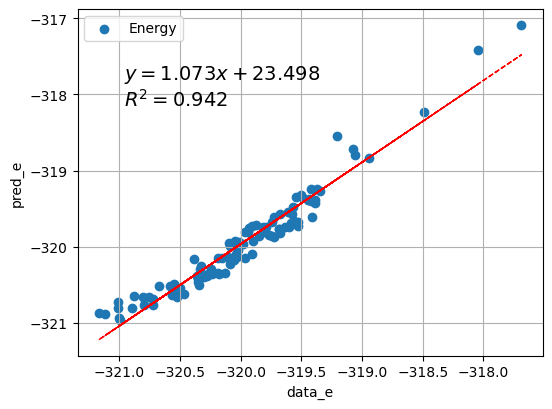

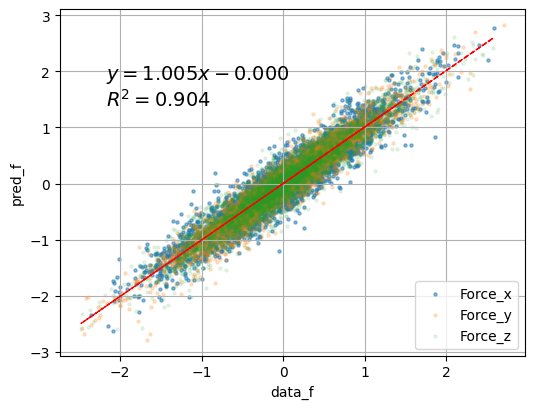

In [13]:
# ===========================================
# STEP 4: SHOW RESULT
# ===========================================
# Run this cell to show the learning curve and the prediction/data

import matplotlib.pyplot as plt
import dpdata
import numpy as np
import os

os.chdir(root_dir+"/01_train/")
data = np.genfromtxt("lcurve.out", names=True)
plt.figure(figsize=(4,3))

# show the learning curve: for loss/error functions
for name in data.dtype.names[1:-1]:
    plt.plot(data["step"], data[name], label=name)
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.xscale("symlog")
plt.yscale("log")
plt.grid()
plt.savefig('lcurve.png')

# and for the prediction/data
from sklearn.metrics import r2_score
data = np.genfromtxt("tests.e.out", skip_header=1)
plt.figure(figsize=(6,4.5))

x = data[:,1]; y = data[:,0]
plt.scatter(x, y, label="Energy"); plt.legend()
plt.xlabel("data_e"); plt.ylabel("pred_e"); plt.grid()

z = np.polyfit(x, y, 1)
yf = np.poly1d(z)(x)
plt.plot(x, yf, 'r--', lw=1)

text = f"$y={z[0]:0.3f} x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,yf):0.3f}$"
plt.gca().text(0.10, 0.72, text, transform=plt.gca().transAxes, fontsize=14)
plt.savefig('tests.e.png'); #plt.clf()


#Force

data = np.genfromtxt("tests.f.out", skip_header=1)
plt.figure(figsize=(6,4.5))

x = data[:,3]; y = data[:,0]
plt.scatter(x, y, s=5, alpha=0.5, label="Force_x"); plt.legend()
x = data[:,4]; y = data[:,1]
plt.scatter(x, y, s=5, alpha=0.2,  label="Force_y"); plt.legend()
x = data[:,5]; y = data[:,2]
plt.scatter(x, y, s=5, alpha=0.1,  label="Force_z"); plt.legend()
plt.xlabel("data_f"); plt.ylabel("pred_f"); plt.grid()

z = np.polyfit(x, y, 1)
yf = np.poly1d(z)(x)
plt.plot(x, yf, 'r--', lw=1)

text = f"$y={z[0]:0.3f} x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,yf):0.3f}$"
plt.gca().text(0.10, 0.72, text, transform=plt.gca().transAxes, fontsize=14)
plt.savefig('tests.f.png'); #plt.clf()